In [1]:
# !pip install perceval-quandela

In [2]:
import perceval as pcvl
import numpy as np
from math import comb
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm as tqdm

In [3]:
nphotons = 4


In [4]:
# Boundary condition 
coefii = 10

# del_0 = 0  #del
# omega_0 = 0     #w
del_0_v = -1/coefii
omega_0_v = 383.9911/coefii

In [5]:
# Differential equation parameters
ws = 376.9911

# ws = 0.376
# coefii = ws/4
K1 = 5/coefii
K2 = 10/coefii
K3 = 1.7/coefii
ws = ws/coefii

# def F(u_zegond,u_prime, u, x):       # DE, works with numpy arrays
#     return u_zegond+np.sin(x)
def F(u_zegond,u_prime, u, x):       # DE, works with numpy arrays
    # print(len(u_zegond))
    # print(len(u_prime))
    # print(len(u))
    delta = u
    delta_prime = u_prime
    omega = delta_prime+ws
    omega_prime = u_zegond
    return (delta_prime+ws-omega)+omega_prime-K1+K2*np.sin(coefii*delta)+K3*(-ws+omega)*coefii

In [6]:
# # Boundary condition (f(x_0)=f_0)
# x_0 = 0
# f_0 = np.sin(0)

In [7]:
# Differential equation's exact solution - for comparison
def u(x):
    return np.sin(x)

In [8]:
# Modeling parameters
n_grid = 350    # number of grid points of the discretized differential equation
range_min = 0  # minimum of the interval on which we wish to approximate our function
range_max = 7  # maximum of the interval on which we wish to approximate our function
X = np.linspace(range_min, range_max-range_min, n_grid)  # Optimisation grid

In [9]:
# Parameters of the quantum machine learning procedure
N = nphotons              # Number of photons
m = nphotons              # Number of modes
eta = 5                   # weight granted to the initial condition
a = 200                   # Approximate boundaries of the interval that the image of the trial function can cover
fock_dim = comb(N + m - 1, N)
# lambda coefficients for all the possible outputs
lambda_random = 2 * a * np.random.rand(fock_dim) - a
# dx serves for the numerical differentiation of f
dx = (range_max-range_min) / (n_grid - 1)

In [10]:
# Input state with N photons and m modes
input_state = pcvl.BasicState([1]*N+[0]*(m-N))
print(input_state)

|1,1,1,1>


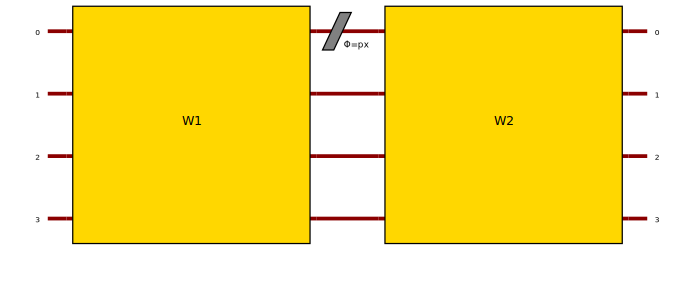

In [11]:
"Haar unitary parameters"
# number of parameters used for the two universal interferometers (2*m**2 per interferometer)
parameters = np.random.normal(size=4*m**2)

px = pcvl.P("px")
c = pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[:2 * m ** 2]), name="W1")\
     // (0, pcvl.PS(px))\
     // pcvl.Unitary(pcvl.Matrix.random_unitary(m, parameters[2 * m ** 2:]), name="W2")

simulator_backend = pcvl.BackendFactory().get_backend("SLOS")
s1 = simulator_backend(pcvl.Matrix.random_unitary(m))
s1.compile(input_state)

pcvl.pdisplay(c)

In [12]:
def computation(params):
    global current_loss
    global computation_count
    "compute the loss function of a given differential equation in order for it to be optimized"
    computation_count += 1

    loss_i = 0 

    delta_0 = None  # boundary condition
    omega_0 = None  # boundary condition

    coefs = lambda_random  # coefficients of the M observable
    # initial condition with the two universal interferometers and the phase shift in the middle
    U_1 = pcvl.Matrix.random_unitary(m, params[:2 * m ** 2])
    U_2 = pcvl.Matrix.random_unitary(m, params[2 * m ** 2:])

    px = pcvl.P("x")
    c = pcvl.Unitary(U_2) // (0, pcvl.PS(px)) // pcvl.Unitary(U_1)

    px.set_value(np.pi * 0)
    U = c.compute_unitary(use_symbolic=False)
    s1.U = U
    delta_0 = np.sum(np.multiply(s1.all_prob(input_state), coefs))
    



    # loss=0


    # Y[0] is before the domain we are interested in (used for differentiation), x_0 is at Y[1]
    Y = np.zeros(n_grid + 2)

    # x_0 is at the beginning of the domain, already calculated
    Y[1] = delta_0

    px.set_value(np.pi * (range_min - dx)/range_max)
    s1.U = c.compute_unitary(use_symbolic=False)
    Y[0] = np.sum(np.multiply(s1.all_prob(input_state), coefs))


    for i in range(1, n_grid):
        x = X[i]
        px.set_value(np.pi * x/range_max)
        s1.U = c.compute_unitary(use_symbolic=False)
        Y[i + 1] = np.sum(np.multiply(s1.all_prob(input_state), coefs))

    px.set_value(np.pi * (range_max + dx)/range_max)
    s1.U = c.compute_unitary(use_symbolic=False)
    Y[n_grid + 1] = np.sum(np.multiply(s1.all_prob(input_state), coefs))


    # Differentiation
    Y_prime = (Y[2:] - Y[:-2])/(2*dx)
    omega_0 = Y_prime[0]+ws

    Y_zegond = (Y_prime[2:] - Y_prime[:-2])/(2*dx)

    loss_i += np.sum((F(Y_zegond,Y_prime[1:-1], Y[2:-2], X[1:-1]))**2)

    # boundary condition given a weight eta
    loss_b = eta * (delta_0 - del_0_v) ** 2 * len(X)
    loss_b += eta * (omega_0 - omega_0_v) ** 2 * len(X)



    current_loss = (loss_i+loss_b) / len(X)
    return current_loss

In [13]:
a = [1,2,3,4,5,6,7,8]
print(a[2:])
print(a[:-2])
print(a[2:-2])


[3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6]
[3, 4, 5, 6]


In [14]:
def callbackF(parameters):
    """callback function called by scipy.optimize.minimize allowing to monitor progress"""
    global current_loss
    global computation_count
    global loss_evolution
    global start_time
    global best_param

    now = time.time()
    pbar.set_description("M= %d Loss: %0.5f #computations: %d elapsed: %0.5f" %
                         (m, current_loss, computation_count, now-start_time))
    pbar.update(1)
    loss_evolution.append((current_loss, now-start_time))
    computation_count = 0
    start_time = now
    best_param = parameters

In [15]:
computation_count = 0
current_loss = 0
start_time = time.time()
loss_evolution = []

pbar = tqdm.tqdm()
res = minimize(computation, parameters, callback=callbackF, method='BFGS', options={'gtol': 1E-2})

M= 4 Loss: 0.08768 #computations: 65 elapsed: 12.10552: : 247it [1:11:19, 12.10s/it] 

In [16]:
# print("Unitary parameters", res.x)
print("Unitary parameters", best_param)


Unitary parameters [ 1.28832134  1.70132213  1.1796078  -4.95188717 -0.12280057 -0.74948138
 -1.09805306  0.14459486 -0.58186868  0.83643635  1.70309607  0.23093465
  1.56464154  1.90598902  3.5915006   0.84233422 -0.13949977 -0.85396416
  0.31539415 -3.2704394   0.45822223  0.37461836 -0.92941889 -1.95739452
 -0.65428772  1.24749901  2.02572308  2.2734053  -2.90974705 -1.62218517
 -0.3116666  -1.50047203 -0.29882639  2.57729881  0.43319142  0.27075266
  0.63856277  1.52553408 -2.69707166 -0.83922011 -0.58224701  0.39169752
  0.27499591  1.0259598  -1.67273135 -1.45591464 -0.10986219  1.60414326
 -0.94248045 -1.13104139  3.90226456 -0.70933326 -0.74472812 -0.4259624
  0.85983125 -0.34744813  0.40174068 -0.80395926  2.31787416 -0.04260668
  0.34319336 -0.32700555 -2.18098714  0.44027208]


In [17]:
def plot_solution(m, N, X, optim_params, lambda_random,label):
    Y = []
    U_1 = pcvl.Matrix.random_unitary(m, optim_params[:2 * m ** 2])
    U_2 = pcvl.Matrix.random_unitary(m, optim_params[2 * m ** 2:])
    px = pcvl.P("x")
    c = pcvl.Unitary(U_2) // (0, pcvl.PS(px)) // pcvl.Unitary(U_1)

    for x in X:
        px.set_value(np.pi * x/range_max)
        U = c.compute_unitary(use_symbolic=False)
        s1.U = U
        f_theta = np.sum(np.multiply(s1.all_prob(input_state), lambda_random))
        Y.append(f_theta)

    
    plt.plot(X, Y, label=label+" Approximation with {} photons".format(N))
    return Y

In [18]:
# y_delta_real = [-0.1, -0.08568864375010266, -0.07135199292327042, -0.05703216366155178, -0.04277533332758968, -0.028630566403092566, -0.014648393492369936, -0.0008786099410683636, 0.012629993562057113, 0.025830965225360485, 0.03868190003112095, 0.05114514907683676, 0.06318818053413534, 0.07478349631699908, 0.08590929364185632, 0.09655108128205876, 0.10669910851327256, 0.11634802541217151, 0.12549688285643618, 0.13414913252475494, 0.1423124546002818, 0.14999727816970396, 0.1572170147933966, 0.16398646160587024, 0.17032150117763253, 0.17623910151518826, 0.18175731606103976, 0.18689528211221512, 0.19167252338163385, 0.1961073022258, 0.2002172705183872, 0.2040196495808423, 0.20753123018238517, 0.21076837254000894, 0.21374700631847987, 0.2164826306303374, 0.21899031403589397, 0.22128469454323552, 0.2233792634241711, 0.22528520015009165, 0.22701309424038968, 0.22857304585789437, 0.22997466468065175, 0.2312270699019247, 0.23233889023019288, 0.23331826388915283, 0.23417283861771784, 0.2349097716700181, 0.2355355471757422, 0.23605508170803655]
# y_omega_real = [38.39911, 38.40131255162024, 38.401559501400065, 38.399627615014815, 38.39535272010845, 38.38863569037213, 38.37944575798523, 38.36781828175373, 38.35385457506316, 38.33771250498817, 38.31960064799821, 38.29975795463622, 38.27844654658136, 38.25594953663366, 38.232548774138536, 38.20852344187769, 38.184133101993716, 38.15961422638989, 38.135180196730154, 38.11102130443908, 38.0873045267779, 38.0641648590319, 38.04170495996719, 38.020008128295665, 37.999139183467754, 37.979144465672405, 37.96005183583712, 37.94187079269068, 37.92460193204962, 37.90823330461032, 37.892744190413474, 37.87811073974539, 37.864305973137945, 37.851299781368624, 37.83905892546051, 37.82754703668229, 37.816724616548235, 37.80654903681822, 37.7969789305147, 37.78797953688034, 37.779515522995986, 37.77155243468513, 37.76405670589686, 37.75699565870589, 37.75033750331248, 37.744051338042496, 37.73810714934741, 37.73247581180426, 37.72712975291509, 37.7220465421391]
y_delta_real = [-0.1, -0.0859350125607893, -0.07184491723011065, -0.05776959286582076, -0.04375273329519621, -0.029840776855475117, -0.016081695412531044, -0.002522848925653373, 0.010789327323780646, 0.02381028113166119, 0.03649918453694085, 0.048819503850006885, 0.06073947953587217, 0.07223210063452638, 0.08327521776469873, 0.09385371380475452, 0.10395729090298077, 0.11357975709004042, 0.12271902627897241, 0.13137711826519113, 0.13956015103169767, 0.1472772003703214, 0.15454011131387166, 0.16136254999809635, 0.16775919525450592, 0.17374573861037296, 0.17933888428873293, 0.18455634920838326, 0.18941673005649415, 0.19393795942903788, 0.19813700303645057, 0.20203041646766443, 0.2056343536127399, 0.2089645666628654, 0.21203640611035743, 0.21486482074866067, 0.2174643576723479, 0.21984916227711973, 0.22203293510609085, 0.22402760341562505, 0.22584349312293203, 0.22749050856461506, 0.2289780964622152, 0.23031524592221128, 0.2315104884360198, 0.23257189787999505, 0.23350709051542912, 0.23432322498855174, 0.23502700233053053, 0.2356246287962067, 0.23612117434350977, 0.23652083467322924, 0.2368275496770117, 0.23704501878064171, 0.23717670094404192, 0.23722581466127302, 0.23719533796053371, 0.23708800840416083, 0.23690632308862916, 0.23665253864455169, 0.2363286712366791, 0.23593647788134034, 0.23547707647205426, 0.2349510685857214, 0.23435893674179709, 0.23370105374549824, 0.23297768268780317, 0.23218897694545174, 0.23133498018094523, 0.2304156263425465, 0.22943073966427985, 0.2283800346659311, 0.22726311615304753, 0.22607947921693786, 0.22482850923467243, 0.22350952093365997, 0.22212189324157783, 0.22066426186548196, 0.21913514875536974, 0.2175331222809461, 0.2158567972316233, 0.21410483481652107, 0.21227594266446673, 0.2103688748239949, 0.20838243176334767, 0.20631546037047468, 0.20416685395303294, 0.20193555223838702, 0.1996205413736088, 0.19722085392547745, 0.19473556888048008, 0.19216381164481114, 0.18950497584330667, 0.1867592746393196, 0.1839257872234101, 0.18100378681978935, 0.1779929563210543, 0.17489338828818793, 0.17170558495055901, 0.1684304582059221, 0.1650693296204179, 0.16162393042857265, 0.15809640153329876, 0.15448929350589416, 0.15080556658604322, 0.14704859068181575, 0.1432221453696674, 0.13933041989443984, 0.13537801316936124, 0.13136993377604433, 0.127311599964488, 0.12320839958994326, 0.11906321213825738, 0.11488415187096246, 0.11068059194335605, 0.10646187346636524, 0.10223730550654728, 0.09801616508608885, 0.09380769718280685, 0.089621114730148, 0.0854655986171885, 0.08135029768863482, 0.07728432874482308, 0.07327677654171919, 0.069336693790919, 0.06547310115964829, 0.06169498727076242, 0.05801130870274664, 0.054430989989716294, 0.05096292362141651, 0.047615970043222225, 0.044398728337166495, 0.041316104439443065, 0.03837438225637305, 0.035580258329445044, 0.032939645466999797, 0.030457672744230675, 0.028138685503183204, 0.02598624535275554, 0.024003130168697918, 0.022191334093613176, 0.020552067536956535, 0.01908575717503535, 0.017792045951009607, 0.01666979307489157, 0.01571707402354572, 0.014931180540689395, 0.01430871376508333, 0.013847612796569132, 0.013544696057144352, 0.013395747079874088, 0.013396225655354112, 0.013541267831710887, 0.013825685914601543, 0.014243968467213932, 0.014790280310266555, 0.015458462522008654, 0.016242032438220092, 0.01713418365221146, 0.018127786014824013, 0.019215385634429687, 0.020389204876931247, 0.021641142365761878, 0.022962772981885603
, 0.02434568486412638, 0.025784703689101417, 0.027272775195513705, 0.028802222180604947, 0.03036561761488629, 0.03195578464213843, 0.03356579657941138, 0.035188976917024696, 0.03681889931856738, 0.03844938762089777, 0.040074515834143794, 0.04168860814170273, 0.04328623890024132, 0.04486223263969581, 0.04641166406327189, 0.04792989095536428, 0.04941314560571711, 0.05085745120377577, 0.052258874145932895, 0.053613815608045526, 0.05491901154543497, 0.056171532692886876, 0.057368784564651304, 0.058508507454442485, 0.059588776435439174, 0.06060800136028434, 0.06156492686108521, 0.06245863234941358, 0.06328853201630541, 0.06405437483226092, 0.06475624454724489, 0.06539455969068621, 0.06596956349290799, 0.0664810078423162, 0.0669294051392388, 0.06731542459228725, 0.06763987775837688, 0.06790371854272685, 0.0681080431988602, 0.06825409032860376, 0.06834324088208824, 0.06837701815774819, 0.06835708780232201, 0.06828525781085194, 0.06816347852668406, 0.06799384264146828, 0.06777858519515839, 0.067520083576012, 0.06722085752059058, 0.06688356911375944, 0.06651102278868772, 0.06610534903785723, 0.06566761971585638, 0.06520048095758416, 0.06470659187731283, 0.0641885615405847, 0.06364894896421203, 0.06309026311627708, 0.06251496291613202, 0.06192545723439909, 0.06132410489297044, 0.06071321466500819, 0.060095045274944456, 0.05947180539848135, 0.05884565366259093, 0.05821869864551522, 0.05759299887676624, 0.056970562837126, 0.056353348958646465, 0.055743265624649506, 0.055142171169727146, 0.05455187380847523, 0.053973663675437815, 0.05340883355942353, 0.05285903109328667, 0.05232578033982004, 0.051810481791755056, 0.051314412371761584, 0.05083872543244803, 0.05038445075636133, 0.049952494555986986, 0.04954363947374897, 0.04915854458200979, 0.04879774538307053, 0.04846165380917074, 0.04815055822248854, 0.047864623415140535, 0.047603890609181895, 0.04736827745660626, 0.04715757803934589, 0.04697148293184464, 0.046809966156262796, 0.04667288580263749, 0.04655994179042358, 0.04647077522980702, 0.04640496842170487, 0.046362044857765336, 0.046341469220367706, 0.04634264738262241, 0.04636492640837097, 0.046407594552186036, 0.046469881259371376, 0.046550957165961866, 0.0466499340987235, 0.04676586507515337, 0.046897744303479726, 0.04704450718266189, 0.04720503030239031, 0.04737813144308656, 0.047562569575903324, 0.04775704486272439, 0.04796019865616468, 0.048171491730338904, 0.04839070061133971, 0.04861664384364325, 0.04884817951645838, 0.04908420789757753, 0.049323671433376584, 0.049565554748815015, 0.04980888464743582, 0.050052730111365455, 0.050296202301313986, 0.05053845455657498, 0.050778682395025525, 0.05101612351312621, 0.05125005778592122, 0.05147980726703821, 0.05170473618868837, 0.051924250961666446, 0.052137800175350676, 0.052344874597702894, 0.05254500717526833, 0.052737773033175894, 0.05292278947513792, 0.053099715983450306, 0.05326826284883769, 0.05342828551749231, 0.05357952385024889, 0.05372170084750165, 0.053854580557660174, 0.05397796807714939, 0.054091709550409615, 0.054195692169896524, 0.054289844176081146, 0.05437413485744989, 0.054448574550504544, 0.05451321463976223, 0.05456814755775546, 0.0546135067850321, 0.05464946685015539, 0.054676243329703944, 0.05469409284827172, 0.05470331307846806, 0.05470424274091766, 0.0546972616042606, 0.0546827904851523, 0.05466129046451264, 0.05463290665728528, 0.05459775599086654, 0.05455620045761724, 0.05450860193454756, 0.05445532218331708, 0.054396722850234724, 0.05433316546625883, 0.05426501144699711, 0.05419262209270664, 0.05411635858829387, 0.05403658200331464, 0.053953653291974185, 0.05386793329312709, 0.05377978273027734, 0.05368956221157828, 0.053597632229832645, 0.05350435316249256, 0.05341008527165949, 0.05331518870408432, 0.053220023491167306, 0.053124949548958064, 0.053030326678155604, 0.05293651456410831, 0.05284387277681395, 0.05275276077091965, 0.052663537885721944, 0.05257656334516673, 0.05249219625784929, 0.05241079561701428]
y_omega_real = [38.39911, 38.40129048236106, 38.401586068402636, 38.39978340139113, 38.39572415011679, 38.389310246965394, 38.38050760179216, 38.36934384646632, 38.3559082940358, 38.34034464358784, 38.322844576960485, 38.30363133871115, 38.28294979172531, 38.26106592524192, 38.23824841949111, 38.2147640240564, 38.19086460697606, 38.16678049343588, 38.14272046576922, 38.118871763456994, 38.09540008436727, 38.07244553096874, 38.05011419107102, 38.02849162479305, 38.00764615137566,
 37.98762884918151, 37.968473555695084, 37.95019686752272, 37.93280120553942, 37.91628286221871, 37.900624415569524, 37.88580473175291, 37.87179975691525, 37.85858251718827, 37.84612311868903, 37.834388747519945, 37.823343669768775, 37.812949231508604, 37.80316416347778, 37.79395221664775, 37.785280190913134, 37.77711480619172, 37.76942361100937, 37.76217498250003, 37.755338126405675, 37.748883077076385, 37.742780697470266, 37.73700267915352, 37.731521542300406, 37.72631091162964, 37.72134819550744, 37.71661332272502, 37.7120869098226, 37.70775023460393, 37.703585236136234, 37.69957451475027, 37.695701332040294, 37.69194961086406, 37.68830393534285, 37.68474955086143, 37.68127236406811, 37.67785906656519, 37.6744987193698, 37.67118144323336, 37.66789763056881, 37.664638063735474, 37.66139391503908, 37.658156746731706, 37.654918511011864, 37.65167155002442, 37.64840859586063, 37.64512277055815, 37.64180758610102, 37.63845694441965, 37.63506513739087, 37.63162701688161, 37.62813951473422, 37.62459886828602, 37.62100152110798, 37.61734461152382, 37.61362597261005, 37.60984413219598, 37.60599831286367, 37.60208843194797, 37.598115101536514, 37.59407962846973, 37.58998401434079, 37.58583095549569, 37.581623843033164, 37.57736676280476, 37.573064495414776, 37.56872251622032, 37.56434688655828, 37.55994523443784, 37.55552855226005, 37.551108992842885, 37.546699648161834, 37.542314549349854, 37.537968666697395, 37.53367790965238, 37.529459126820235, 37.52533010596386, 37.52130957400363, 37.51741719701744, 37.51367358024063, 37.51010026806605, 37.50671974404403, 37.50355543088238, 37.500631690446404, 37.49797382375888, 37.49560807100009, 37.493559276794656, 37.49183428294778, 37.49045890956581, 37.489461877339174, 37.4888685704348, 37.48870103649613, 37.48897798664307, 37.48971479547204, 37.490923501055946, 37.49261280494421, 37.49478807216271, 37.49745133121387, 37.500601274076566, 37.504233256206184, 37.50833929653462, 37.51290807747025, 37.51792494489794, 37.523371908179065, 37.52922764015149, 37.53546747712958, 37.54206445086386, 37.54900330840227, 37.556255944956405, 37.56378860644808, 37.57156768992246, 37.579559743548074, 37.5877314666168, 37.59604970954388, 37.604481473867885, 37.61299391225078, 37.62155432847785, 37.63013017745775, 37.63868906522249, 37.64719874892743, 37.655627136851294, 37.66394228839615, 37.672112961005055, 37.68011946937303, 37.68793741793503, 37.69554004269064, 37.70290272380841, 37.71000298562585, 37.71682049664943, 37.72333706955457, 37.729536661185634, 37.73540537255596, 37.74093144884784, 37.74610527941251, 37.750919397770176, 37.755368481609985, 37.75944935279005, 37.76316097733743, 37.76650446544816, 37.769482432179835, 37.772092575210166, 37.774337102344234, 37.77622090004435, 37.77774994114467, 37.77893128485119, 37.779773076741755, 37.78028454876605, 37.780476019245604, 37.78035889287379, 37.779945660715825, 37.77924990020877, 37.77828627516152, 37.777070535754824, 37.77561951854128, 37.77395078254633, 37.77207506558927, 37.770006568134114, 37.76776196631399, 37.76535751244761, 37.762809035039275, 37.76013193877888, 37.75734120454191, 37.75445138938941, 37.75147662656804, 37.74843062551004, 37.74532667183323, 37.742177627341036, 37.73899593002244, 37.73579359405204, 37.73258220979, 37.729372943782096, 37.72617528609058, 37.722997642374104, 37.71985027793003, 37.71674290915241, 37.713684658980796, 37.710684056900234, 37.707749038941266, 37.70488694767991, 37.70210453223769, 37.69940794828162, 37.69680275802421, 37.694293930223466, 37.69188584018288, 37.689582269751426, 37.687386407323594, 37.68530084783936, 37.68332759278418, 37.68146805018902, 37.67972303463032, 37.67809355829574, 37.67658220747864, 37.67519048700885, 37.67391947473086, 37.67276986724288, 37.67174197989688, 37.67083574679857, 37.67005072080742, 37.6693860735366, 37.66884059535308, 37.66841269537753, 37.668100401484395, 37.66790136030184, 37.6678128372118, 37.66783171634993, 37.667954500605646, 37.6681773116221, 37.66849588979619, 37.66890559427856, 37.669401402973605, 37.669977912937405, 37.67063220392367, 37.67136165360233, 37.67216122492427, 37.6730258982237, 37.67395067121826, 37.67493055900894, 37.67596059408014, 37.67703582629962, 37.67815132291856, 37.679302168571475, 37.6804834652763, 37.68169033243435, 37.68291790683031, 37.68416134263226, 37.68541581139166, 37.68667650204335, 37.68793862090556, 37.68919739167991, 37.69044821925161, 37.69168912133674, 37.69291639803234, 37.69412560895574, 37.69531259582906, 37.69647348247922, 37.697604674837926, 37.698702860941665, 37.699765010931735, 37.7007883770542, 37.701770493659936, 37.702709177204575, 37.70360252624858, 37.70444892145717, 37.705247025600386, 37.70599578355302, 37.70669442229468, 37.70734245090977, 37.70793966058746, 37.70848612462173, 37.708982198411334, 37.70942851945983, 37.709825327975594, 37.710172348644306, 37.710469934076876, 37.71071856757137, 37.7109188614328, 37.71107155697319, 37.7111775245115, 37.71123776337371, 37.711253401892755, 37.711225697408544, 37.71115603626799, 37.711045933824934, 37.71089703444025, 37.710711111481764, 37.71049006732427, 37.710235933349566, 37.7099508699464, 37.70963716651051, 37.70929724144461, 37.70893364215841, 37.70854904506856, 37.70814625559872, 37.70772820817951, 37.70729774052432, 37.70685410432432, 37.70639836885115, 37.705932740650034, 37.70545934178291, 37.7049802098284, 37.704497297881765, 37.70401247455497, 37.70352752397666, 37.70304414579214, 37.7025639551634, 37.702088482769106, 37.701619174804605, 37.70115739298192, 37.700704414529746, 37.70026143219346, 37.69982955423511, 37.69940980443342, 37.69900312208381, 37.698610361998355, 37.698232294505814, 37.69786960262264, 37.697521814132905, 37.69718895762734, 37.69687201671962, 37.696571877817576, 37.69628933012322, 37.69602506563273, 37.69577967913645, 37.695553668218864, 37.695347433258654, 37.69516127742864, 37.69499540669583, 37.69484992982139, 37.69472485836064, 37.69462010666307, 37.69453549187235, 37.694470733926295, 37.694425455556896, 37.69439918229031, 37.69439134244685, 37.694401267141, 37.6944281902814, 37.694471248570885, 37.694529481506414, 37.694601831379146, 37.69468714327438, 37.69478416507159, 37.69489154744442, 37.69500784386067, 37.69513151058232]


Text(0, 0.5, 'del_t')

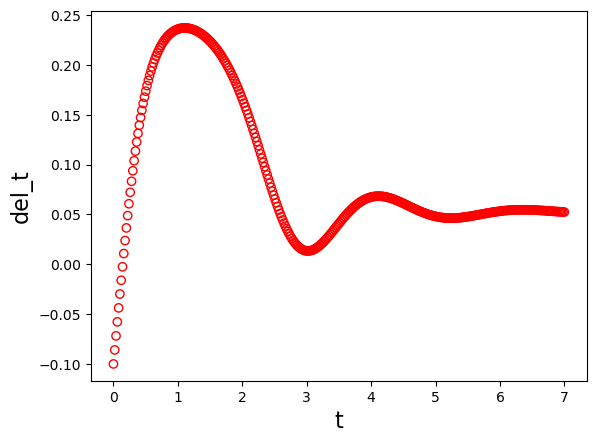

In [19]:
plt.figure()

plt.scatter(X,y_delta_real,facecolors='none', edgecolors='r', label='True - del_t')
# plt.scatter(X,pred_train_X, color='red',marker="x",s=4,label='Prediction - del_t')
plt.xlabel('t',fontsize=16)
plt.ylabel('del_t',fontsize=16)

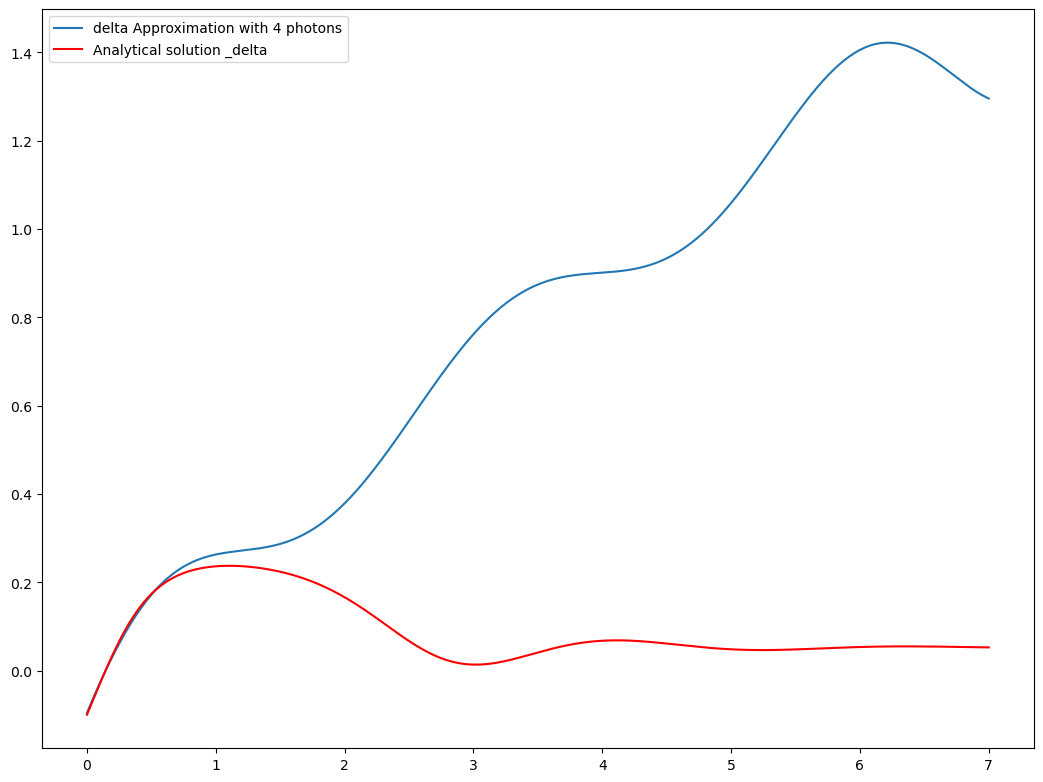

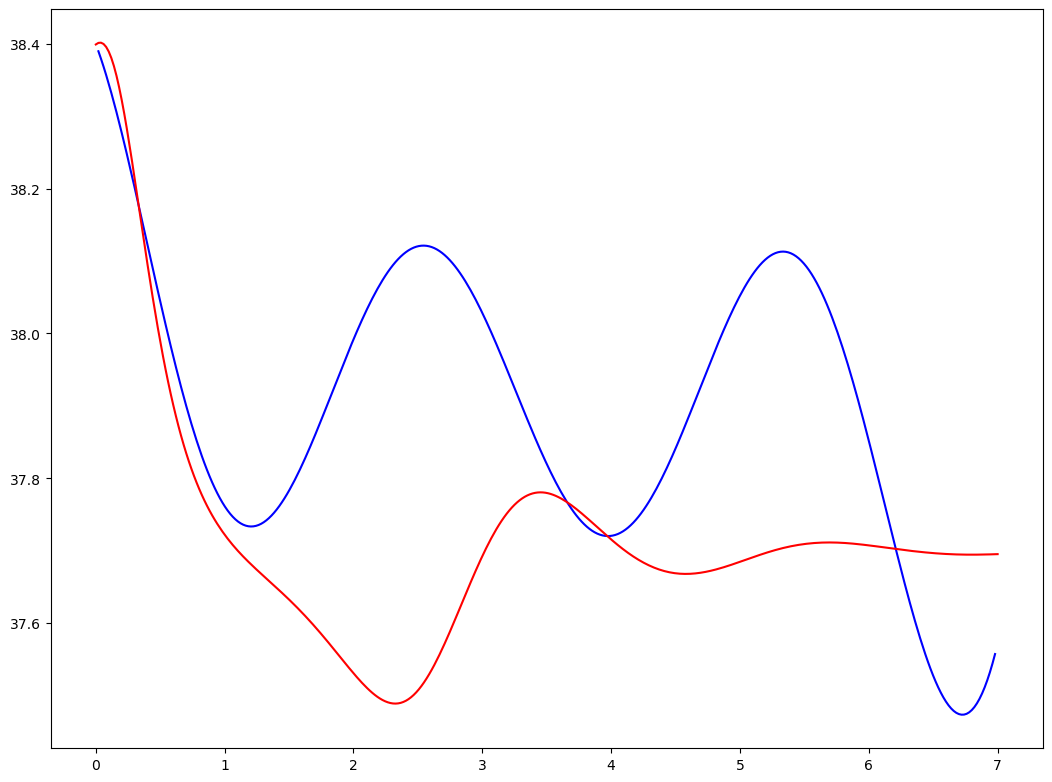

In [20]:
# X = np.linspace(range_min, range_max, 50)

# Change the plot size
default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [2 * value for value in default_figsize]

# delta_pred = plot_solution(m, N, X, res.x, lambda_random,'delta')
delta_pred = plot_solution(m, N, X, best_param, lambda_random,'delta')

plt.plot(X, y_delta_real, 'r', label='Analytical solution _delta')
plt.legend()

plt.figure()

delta_pred = np.array(delta_pred)
delta_prime = (delta_pred[2:] - delta_pred[:-2])/(2*dx)
omega = delta_prime+ws
plt.plot(X[1:-1], omega, 'b', label='prediction solution _omega')
plt.plot(X, y_omega_real, 'r', label='Analytical solution _omega')
# plt.legend()


plt.show()

Text(0, 0.5, 'Loss function value')

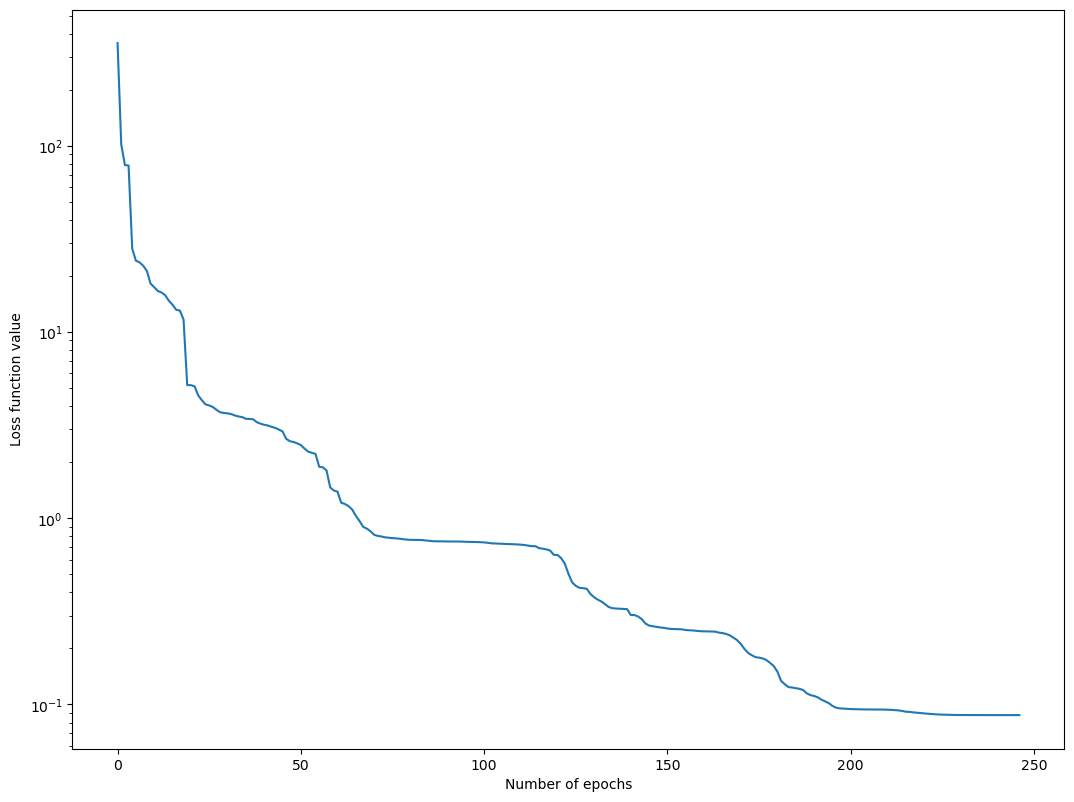

In [21]:

plt.plot([v[0] for v in loss_evolution])
plt.yscale("log")
plt.xlabel("Number of epochs")
plt.ylabel("Loss function value")